# **Classificazione su un dataset affetto da rumore** #

## 1) Importo le librerie e il dataset e lo estraggo e ottengo, dai dati del dataset, il train, test e validation sets. (stesso codice usato nel homework2) ##

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import os


data_path = '/kaggle/input/cifar10/cifar-10-batches-py'

# Funzione per il fethc del dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Caricamento dei 5 batch di training
X_list = []
y_list = []

for i in range(1, 6):
    batch = unpickle(os.path.join(data_path, f'data_batch_{i}'))
    X_list.append(batch[b'data'])
    y_list.extend(batch[b'labels'])

# Caricamento dei dati
test_batch = unpickle(os.path.join(data_path, 'test_batch'))
X_list.append(test_batch[b'data'])
y_list.extend(test_batch[b'labels'])

# Concatenazione unico array
X = np.concatenate(X_list)
y = np.array(y_list)

# Sottocampionamento a 2000 esempi (Segmento di codice usato per la prova del progetto)
#subset_size = 2000
#np.random.seed(42)
#indices = np.random.choice(len(X), subset_size, replace=False)
#X = X[indices]
#y = y[indices]


In [2]:
# Shuffle prima di suddividere
shuffle_idx = np.random.permutation(len(X))
X = X[shuffle_idx]
y = y[shuffle_idx]

# Uso le proporzioni per il train, validation e test set
train_fraction = 0.6  
validation_fraction = 0.2  
test_fraction = 0.2

num_train = int(train_fraction * X.shape[0])
num_val = int(validation_fraction * X.shape[0])
X_train = X[:num_train]
y_train = y[:num_train]
X_val = X[num_train:num_train+num_val]
y_val = y[num_train:num_train+num_val]
X_test = X[num_train+num_val:]
y_test = y[num_train+num_val:]

# Standardizzazione
scaler = StandardScaler()
train_set = scaler.fit_transform(X_train)
val_set = scaler.transform(X_val)
test_set = scaler.transform(X_test)

print("Train:", train_set.shape, " Val:", val_set.shape, " Test:", test_set.shape)

Train: (36000, 3072)  Val: (12000, 3072)  Test: (12000, 3072)


## 2) Creazione MLT con i 3 modelli ##


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .........alpha=0.0001, hidden_layer_sizes=(512, 64); total time= 4.3min
[CV] END .........alpha=0.0001, hidden_layer_sizes=(512, 64); total time= 4.8min
[CV] END .........alpha=0.0001, hidden_layer_sizes=(512, 64); total time= 5.7min
[CV] END ........alpha=0.0001, hidden_layer_sizes=(512, 256); total time= 7.2min
[CV] END ....alpha=0.0001, hidden_layer_sizes=(256, 128, 64); total time= 1.8min
[CV] END ....alpha=0.0001, hidden_layer_sizes=(256, 128, 64); total time= 2.5min
[CV] END ....alpha=0.0001, hidden_layer_sizes=(256, 128, 64); total time= 2.4min
[CV] END ........alpha=0.0001, hidden_layer_sizes=(512, 256); total time= 5.6min
[CV] END ........alpha=0.0001, hidden_layer_sizes=(512, 256); total time= 6.7min
[CV] END ..........alpha=0.001, hidden_layer_sizes=(512, 64); total time= 3.2min
[CV] END ..........alpha=0.001, hidden_layer_sizes=(512, 64); total time= 4.5min
[CV] END ..........alpha=0.001, hidden_layer_size

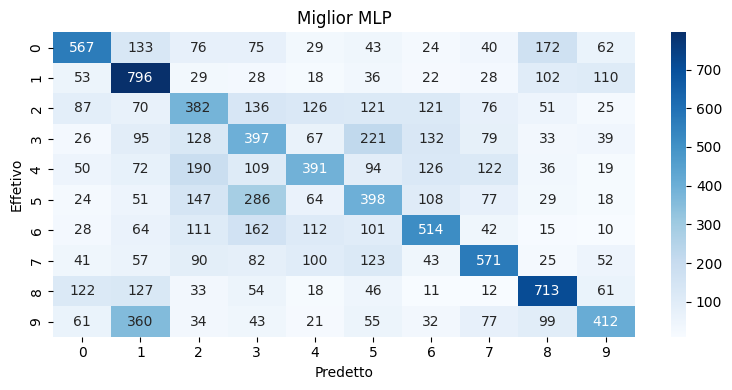


📋 Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.46      0.50      1221
           1       0.44      0.65      0.52      1222
           2       0.31      0.32      0.32      1195
           3       0.29      0.33      0.31      1217
           4       0.41      0.32      0.36      1209
           5       0.32      0.33      0.33      1202
           6       0.45      0.44      0.45      1159
           7       0.51      0.48      0.49      1184
           8       0.56      0.60      0.58      1197
           9       0.51      0.35      0.41      1194

    accuracy                           0.43     12000
   macro avg       0.43      0.43      0.43     12000
weighted avg       0.43      0.43      0.43     12000



In [3]:

# Creazione dei modelli
param_grid = {
    'hidden_layer_sizes': [(512, 64), (512, 256), (256, 128, 64)],
    'alpha': [1e-4, 1e-3, 1e-5]
}

mlp = MLPClassifier(
    max_iter=100,
    early_stopping=True,
    validation_fraction=0.1,
    learning_rate='adaptive',
    batch_size=64,
    random_state=42
)

# Grid search con validazione incrociata
grid = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(val_set, y_val)

# Miglior modello
best_model = grid.best_estimator_
print("\n Miglior configurazione trovata:")
print(grid.best_params_)

train_acc = accuracy_score(y_train, best_model.predict(train_set))
val_acc = accuracy_score(y_val, best_model.predict(val_set))
test_acc = accuracy_score(y_test, best_model.predict(test_set))

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = best_model.predict(test_set)
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title("Miglior MLP")
plt.xlabel("Predetto")
plt.ylabel("Effetivo")
plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred))